# Import 

In [1]:
import pandas as pd
import tensorflow
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation,Conv2D,Reshape
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import *
import math
import time
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
df = pd.read_csv('data/1101.csv' , encoding='big5')
df['RSI 6'].str.replace('%','')

0       57.42
1       67.72
2       79.57
3       77.94
4       49.34
5       39.68
6       47.30
7       48.76
8       52.92
9       62.15
10      48.03
11      40.15
12      29.03
13      24.01
14      37.55
15      56.82
16      47.33
17      37.96
18      47.99
19      56.45
20      51.79
21      55.46
22      35.18
23      25.05
24      33.73
25      27.34
26      22.17
27      19.39
28      36.20
29      40.45
        ...  
1641    68.75
1642    56.07
1643    56.07
1644    65.29
1645    38.58
1646    28.43
1647    50.09
1648    45.58
1649    34.41
1650    36.49
1651    35.15
1652    40.38
1653    53.80
1654    66.04
1655    79.73
1656    82.25
1657    68.02
1658    69.81
1659    70.79
1660    59.24
1661    64.76
1662    78.64
1663    68.52
1664    71.19
1665    87.60
1666    71.35
1667    74.02
1668    68.88
1669    74.68
1670    74.68
Name: RSI 6, Length: 1671, dtype: object

# Read Date

In [35]:
def batch_data(stock_num,time_steps,sd,batch_size,feature_list):

    df = pd.read_csv('data/'+str(stock_num)+'.csv' , encoding='big5')
#     print(df.shape)
#     df=df[:-7]
#     print(df.shape)
    df['RSI6'] = df['RSI 6'].str.replace('%','')
    df['RSI6'] = df['RSI6'].astype('float')

#     df['RSI6'] = df['RSI 6'] * 0.01
#     df['RSI12'] = df['RSI 12'].str.replace('%','').astype('float')
#     df['RSI12'] = df['RSI12'] * 0.01
    
    
#     del df['Date']
#     del df['DIF']
#     del df['K']
#     del df['D']
#     del df['MACD9']
#     del df['OSC']
#     del df['SMA60']
#     del df['MA10']
#     del df['MA5']
#     del df['SMA20']
#     del df['SMA10']    print()

    #_data = df.drop(['Date'],['DIF'],['K'],['D'],['MACD9'],['OSC'], axis=1)
    #df.drop(['Date'],axis=1)
    # df.drop(['DIF'],axis=1)
    # df.drop(['K'],axis=1)
    # df.drop(['D'],axis=1)
    # df.drop(['MACD9'],axis=1)
    # df.drop(['OSC'],axis=1)
    df['K'] = df['K'].str.replace('%','').astype('float')
    df['K'] = df['K'] * 0.01
    
    df['D'] = df['D'].str.replace('%','').astype('float')
    df['D'] = df['D'] * 0.01

    df['Vol']= df['Vol'].astype('float')
    df['Open'] = df['Open'].astype('float')
    df['High'] = df['High'].astype('float')
    df['Low'] = df['Low'].astype('float')
    df['Close'] = df['Close'].astype('float')
    df['SMA5'] = df['SMA5'].astype('float')
    df['SMA10'] = df['SMA10'].astype('float')
    df['SMA20'] = df['SMA20'].astype('float')
    df['SMA60'] = df['SMA60'].astype('float')
    df['MA5'] = df['MA5'].astype('float')
    df['MA10'] = df['MA10'].astype('float')
    
    
#     sd = -1
    close = df['Close']
    s = 0.07
    
    df['three']=((close.shift(-3)-close)/close>s).astype('int')
    df['four']=((close.shift(-4)-close)/close>s).astype('int')
    df['five']=((close.shift(-5)-close)/close>s).astype('int')
    df['six']=((close.shift(-6)-close)/close>s).astype('int')
    df['seven']=((close.shift(-7)-close)/close>s).astype('int')
    df['eight']=((close.shift(-8)-close)/close>s).astype('int')
    df['nine']=((close.shift(-9)-close)/close>s).astype('int')
    df['ten']=((close.shift(-10)-close)/close>s).astype('int')
    df['eleven']=((close.shift(-11)-close)/close>s).astype('int')
    
    df['label'] = df['three']+df['four']+df['five']+df['six']+df['seven']+df['eight']+df['nine']+df['ten']+df['eleven']
    df['label'] = (df['label']>0).astype('int')
    Y =df['label']
    Y = np_utils.to_categorical(Y)
    #first time train
    #X = df[['Vol','Open','High','Low','Close']]
    # acc 65
    
    #second
    #X = df[['Vol','Open','High','Low','Close','MA5']]
    
    #third
    #X = df[['Vol','Open','High','Low','Close','MA5','MA10']]
    
    #4
    X = df[feature_list]
    #X = df[['Vol','Open','High','Low','Close','MA5','MA10','SMA5','SMA10','SMA20']]
    

    Y = np.array(Y)
    X = np.array(X)
    
    m = MinMaxScaler(feature_range=(0,1))
    X=m.fit_transform(X)

    X_t = []
    Y_t = []
    
    
    
    
    for i in range(0, X.shape[0] - time_steps):
        

        X_t.append(X[i:i+time_steps])
        Y_t.append(Y[i+time_steps])
    X_t = np.array(X_t)
    Y_t = np.array(Y_t)
    
    dn = X_t.shape[0]%batch_size
    X_t = X_t[dn:]
    Y_t = Y_t[dn:]
    
    
      
#     X_t,Y_t=shuffle(X_t, Y_t, random_state=0)
    
    X_t_batch_train=X_t[:-batch_size]
    Y_t_batch_train=Y_t[:-batch_size]

    X_t_batch_test=X_t[-batch_size:]
    Y_t_batch_test=Y_t[-batch_size:]
    return X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test,df
    
    

In [36]:
stocks=['1101','2327','2371','2478','2498','3008','3443','3665']


1101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(128, 6, 8..., return_sequences=True, stateful=False, units=256)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, stateful=False, units=128)`


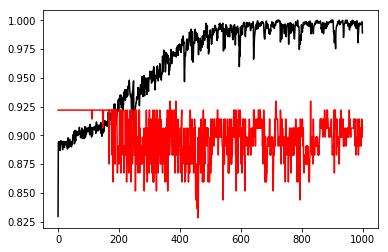

1536/1536 [==============================] - 0s 37us/step
train_score: [0.03507413535650509, 0.9856770833333334]
128/128 [==============================] - 0s 38us/step
test_score: [0.7825697660446167, 0.90625]
----
28.1 32.84
----
41.25 57.46
----
56.29 44.97
----
43.67 57.78
----
71.28 71.22
----
49.59 66.8
profit: 3.0500000000000043
---------------
[[33.55, 2, 'BUY'], [33.65, 16, 'SELL'], [33.6, 27, 'BUY'], [34.1, 41, 'SELL'], [34.45, 42, 'BUY'], [36.15, 46, 'SELL'], [37.3, 66, 'BUY'], [35.95, 80, 'SELL'], [36.3, 88, 'BUY'], [37.0, 102, 'SELL'], [36.6, 103, 'BUY'], [38.0, 117, 'SELL']]


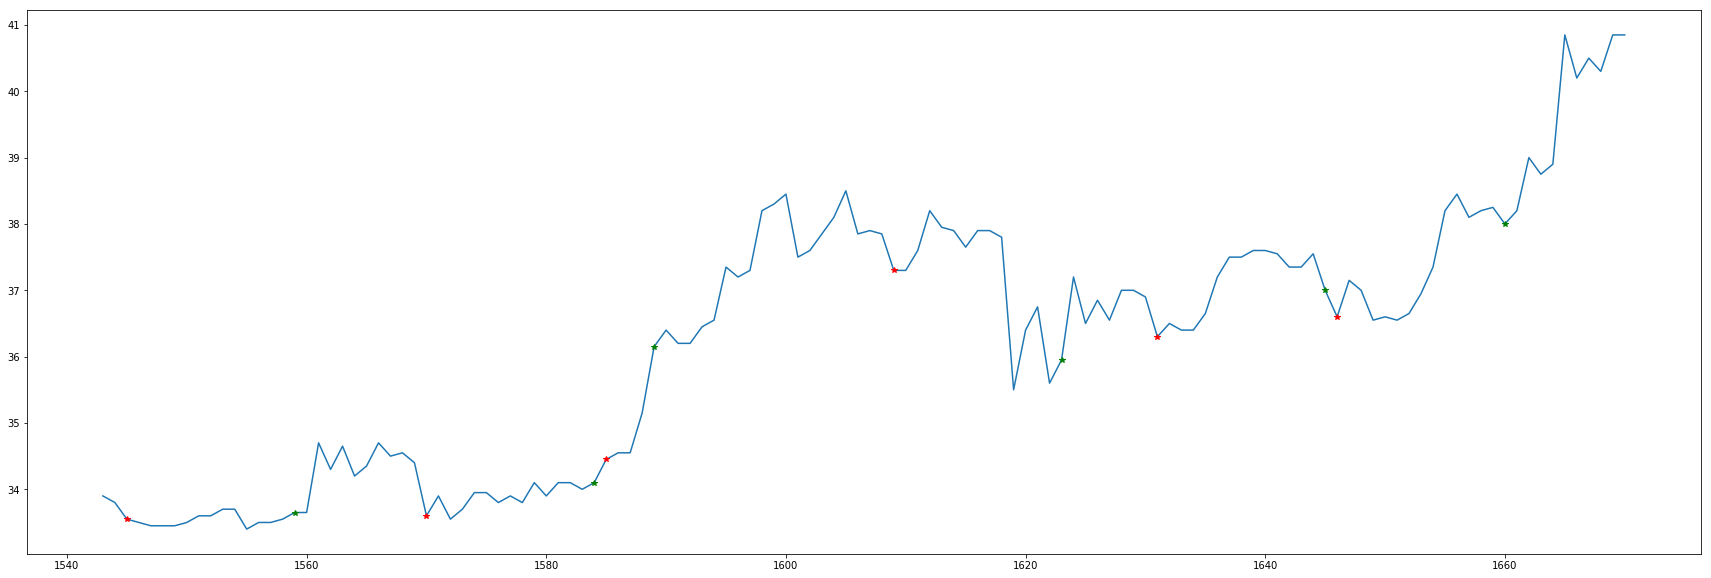

2327


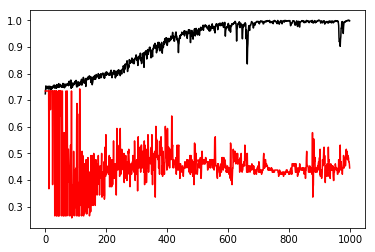

1408/1408 [==============================] - 0s 36us/step
train_score: [0.07632338359381018, 0.9893465909090909]
128/128 [==============================] - 0s 53us/step
test_score: [7.151042938232422, 0.4453125]
----
58.64 64.28
----
76.52 72.98
----
78.89 73.72
----
79.04 76.63
----
87.99 82.02
----
76.3 85.58
----
72.08 59.71
----
70.45 78.12
----
58.9 60.54
----
34.11 42.33
----
80.42 62.23
----
86.52 75.52
----
91.85 83.68
----
92.45 88.15
----
96.47 92.44
----
88.43 91.85
----
80.33 84.29
----
59.61 73.27
----
65.54 64.21
----
80.87 76.51
----
54.48 68.92
profit: 548.0
---------------
[[231.0, 0, 'BUY'], [248.0, 4, 'SELL'], [251.5, 8, 'BUY'], [270.0, 19, 'SELL'], [293.0, 20, 'BUY'], [289.0, 21, 'SELL'], [290.0, 22, 'BUY'], [298.5, 23, 'SELL'], [300.0, 24, 'BUY'], [315.0, 25, 'SELL'], [310.0, 30, 'BUY'], [339.5, 41, 'SELL'], [333.0, 42, 'BUY'], [389.0, 52, 'SELL'], [379.5, 57, 'BUY'], [415.0, 65, 'SELL'], [373.0, 69, 'BUY'], [400.0, 74, 'SELL'], [354.0, 76, 'BUY'], [383.5, 89, 'SEL

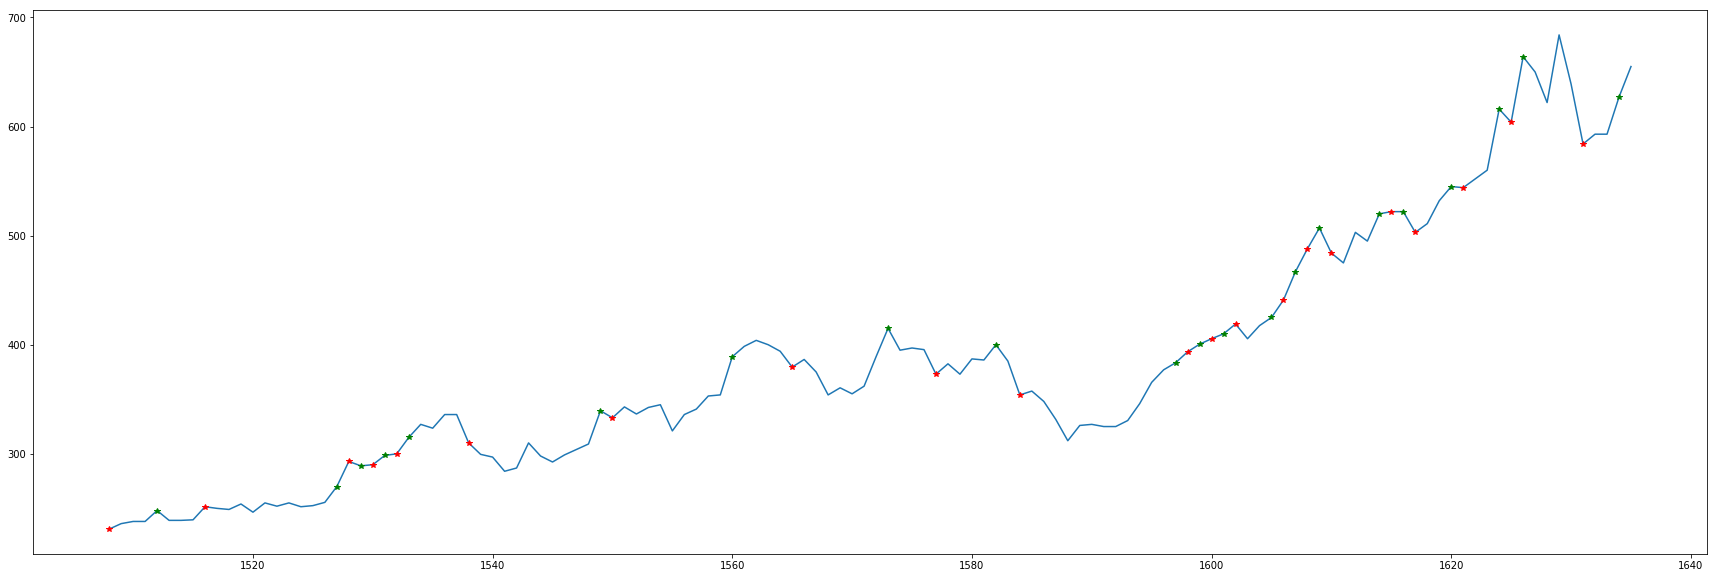

2371


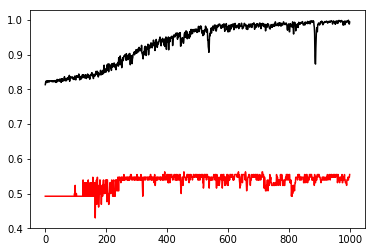

1536/1536 [==============================] - 0s 37us/step
train_score: [0.003375671127966958, 0.9993489583333334]
128/128 [==============================] - 0s 49us/step
test_score: [7.092804908752441, 0.5546875]
----
50.46 52.85
----
71.08 70.51
----
78.93 60.33
----
71.46 81.86
----
72.22 69.71
----
56.94 70.67
----
72.17 66.7
----
95.17 88.58
----
89.25 88.87
----
87.56 88.51
----
36.78 58.03
----
51.68 64.99
----
52.0 49.03
----
72.15 69.02
----
47.58 66.36
profit: 13.399999999999995
---------------
[[13.0, 0, 'BUY'], [14.2, 3, 'SELL'], [13.9, 9, 'BUY'], [15.35, 20, 'SELL'], [16.4, 21, 'BUY'], [17.15, 23, 'SELL'], [17.55, 30, 'BUY'], [18.8, 39, 'SELL'], [18.2, 41, 'BUY'], [19.65, 44, 'SELL'], [17.7, 45, 'BUY'], [19.1, 48, 'SELL'], [19.3, 49, 'BUY'], [20.55, 54, 'SELL'], [22.6, 55, 'BUY'], [22.15, 56, 'SELL'], [23.6, 57, 'BUY'], [23.55, 58, 'SELL'], [24.1, 59, 'BUY'], [25.05, 60, 'SELL'], [23.35, 68, 'BUY'], [25.1, 81, 'SELL'], [24.05, 89, 'BUY'], [22.4, 103, 'SELL'], [21.1, 106, 'B

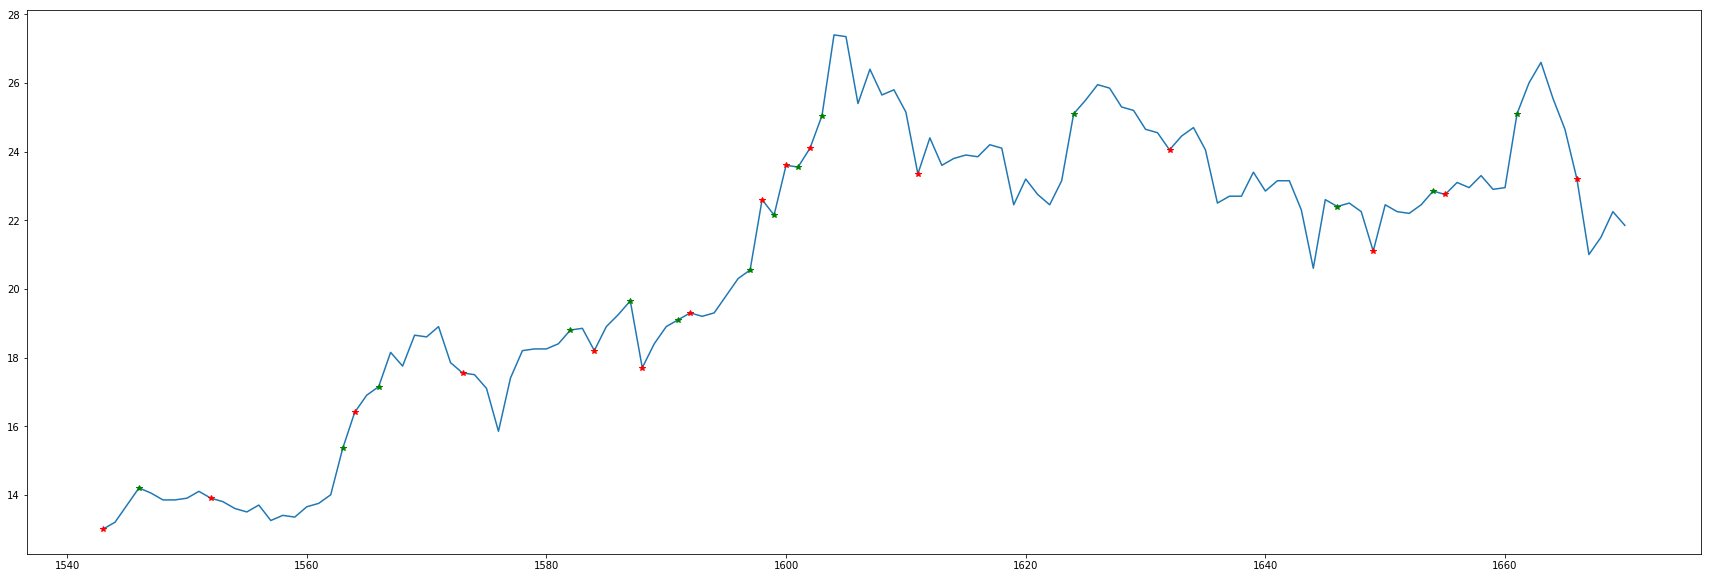

2478


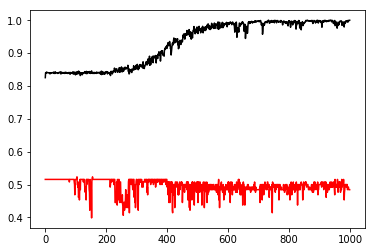

1408/1408 [==============================] - 0s 35us/step
train_score: [2.2287851209057408e-06, 1.0]
128/128 [==============================] - 0s 55us/step
test_score: [8.121100425720215, 0.484375]
----
26.17 29.43
----
60.38 59.31
----
34.46 51.5
----
60.72 55.64
----
85.35 73.14
----
87.11 81.85
----
72.68 81.29
----
21.98 31.84
----
52.75 37.23
----
18.29 27.96
----
77.39 57.19
----
87.37 77.88
----
84.69 83.16
----
63.68 75.88
profit: 36.95000000000002
---------------
[[24.65, 1, 'BUY'], [24.35, 15, 'SELL'], [24.15, 16, 'BUY'], [27.0, 24, 'SELL'], [24.9, 33, 'BUY'], [26.9, 41, 'SELL'], [26.4, 42, 'BUY'], [29.6, 45, 'SELL'], [32.55, 46, 'BUY'], [33.6, 48, 'SELL'], [35.5, 49, 'BUY'], [37.5, 50, 'SELL'], [35.3, 55, 'BUY'], [38.2, 65, 'SELL'], [33.7, 68, 'BUY'], [30.9, 82, 'SELL'], [32.5, 83, 'BUY'], [35.3, 87, 'SELL'], [33.75, 98, 'BUY'], [38.85, 110, 'SELL'], [42.7, 111, 'BUY'], [46.6, 114, 'SELL'], [50.0, 115, 'BUY'], [54.7, 116, 'SELL'], [49.25, 117, 'BUY'], [53.7, 119, 'SELL'], [

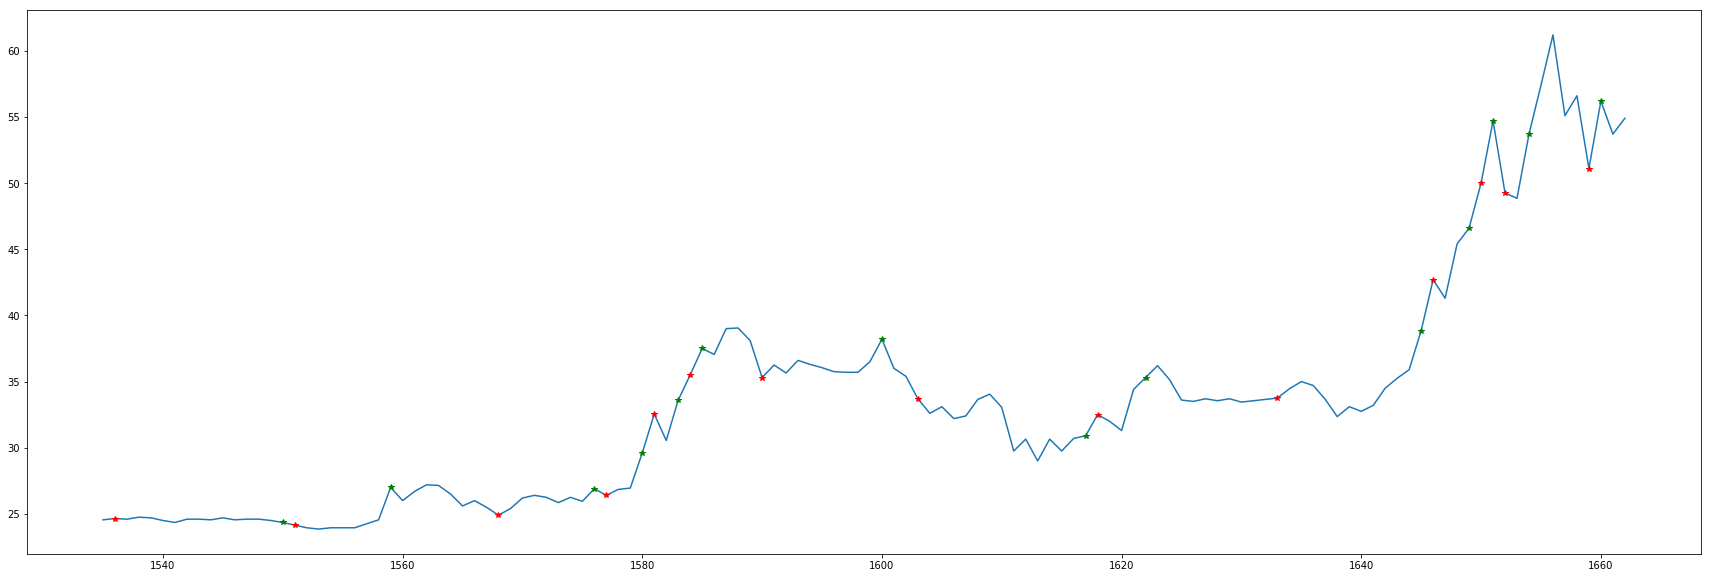

2498


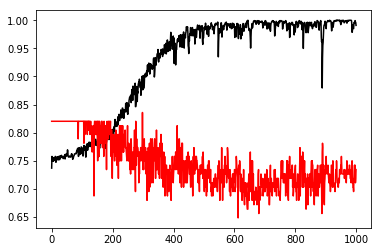

1536/1536 [==============================] - 0s 38us/step
train_score: [0.014398911361543773, 0.9967447916666666]
128/128 [==============================] - 0s 41us/step
test_score: [2.3903746604919434, 0.734375]
----
25.31 21.01
----
20.3 19.96
----
28.13 35.86
----
21.41 37.17
----
27.02 28.82
----
30.33 33.88
----
40.42 53.99
----
43.52 51.68
profit: 3.3000000000000114
---------------
[[70.4, 0, 'BUY'], [67.4, 14, 'SELL'], [66.7, 15, 'BUY'], [67.4, 29, 'SELL'], [68.1, 32, 'BUY'], [73.0, 41, 'SELL'], [70.8, 57, 'BUY'], [71.4, 71, 'SELL'], [68.6, 75, 'BUY'], [60.5, 89, 'SELL'], [60.5, 90, 'BUY'], [67.6, 100, 'SELL'], [63.0, 103, 'BUY'], [68.1, 108, 'SELL'], [64.5, 112, 'BUY'], [60.5, 126, 'SELL']]


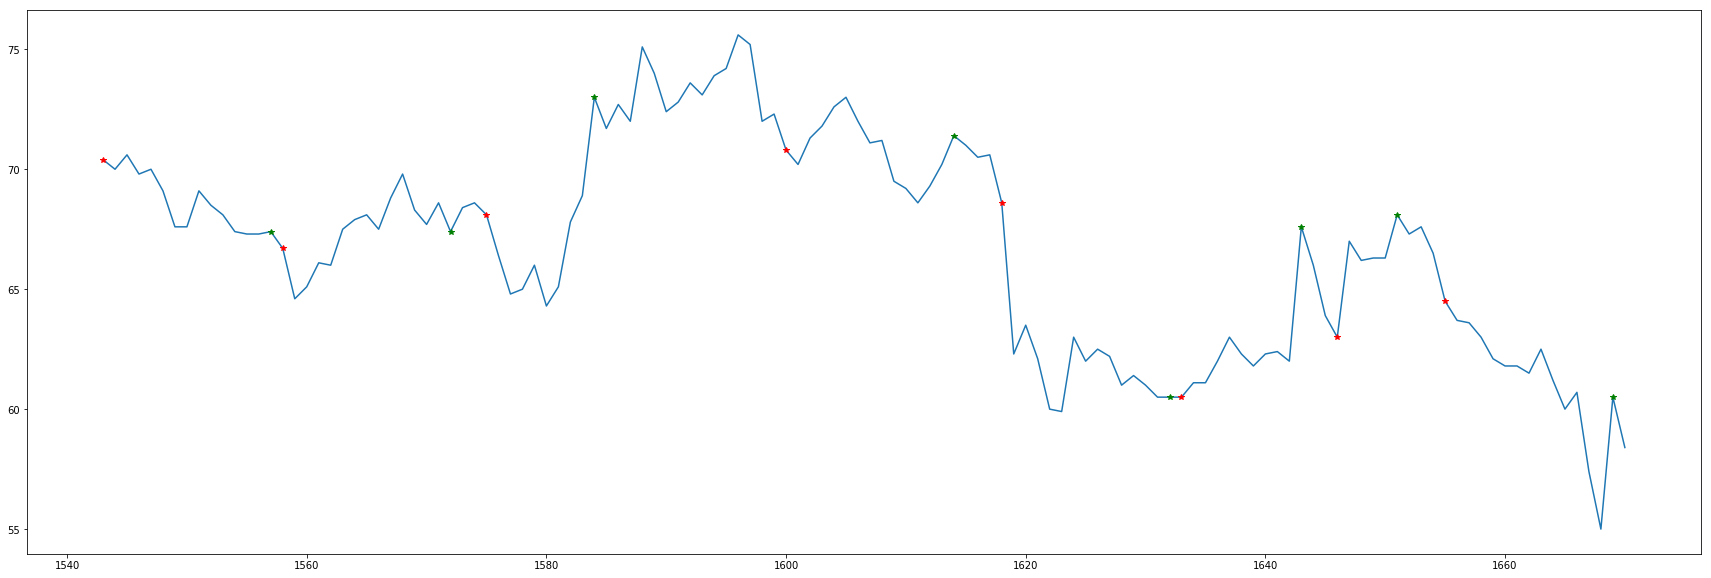

3008


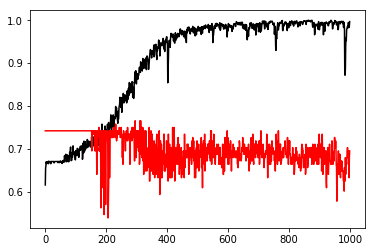

1536/1536 [==============================] - 0s 37us/step
train_score: [0.0017543682236767684, 0.9993489583333334]
128/128 [==============================] - 0s 59us/step
test_score: [3.431227684020996, 0.6953125]
----
57.51 64.77
----
34.62 53.08
----
15.51 17.1
----
18.35 22.38
----
32.3 40.74
----
52.49 61.4
----
27.88 40.15
----
45.31 53.23
----
19.71 12.61
----
73.64 70.94
profit: -550.0
---------------
[[5575.0, 0, 'BUY'], [5985.0, 10, 'SELL'], [5700.0, 16, 'BUY'], [5010.0, 30, 'SELL'], [4800.0, 31, 'BUY'], [4200.0, 45, 'SELL'], [4000.0, 46, 'BUY'], [4030.0, 60, 'SELL'], [3790.0, 67, 'BUY'], [4080.0, 73, 'SELL'], [3800.0, 75, 'BUY'], [3655.0, 89, 'SELL'], [3690.0, 90, 'BUY'], [3955.0, 93, 'SELL'], [3690.0, 97, 'BUY'], [3000.0, 111, 'SELL'], [3250.0, 112, 'BUY'], [3550.0, 116, 'SELL'], [3420.0, 120, 'BUY'], [3700.0, 127, 'SELL']]


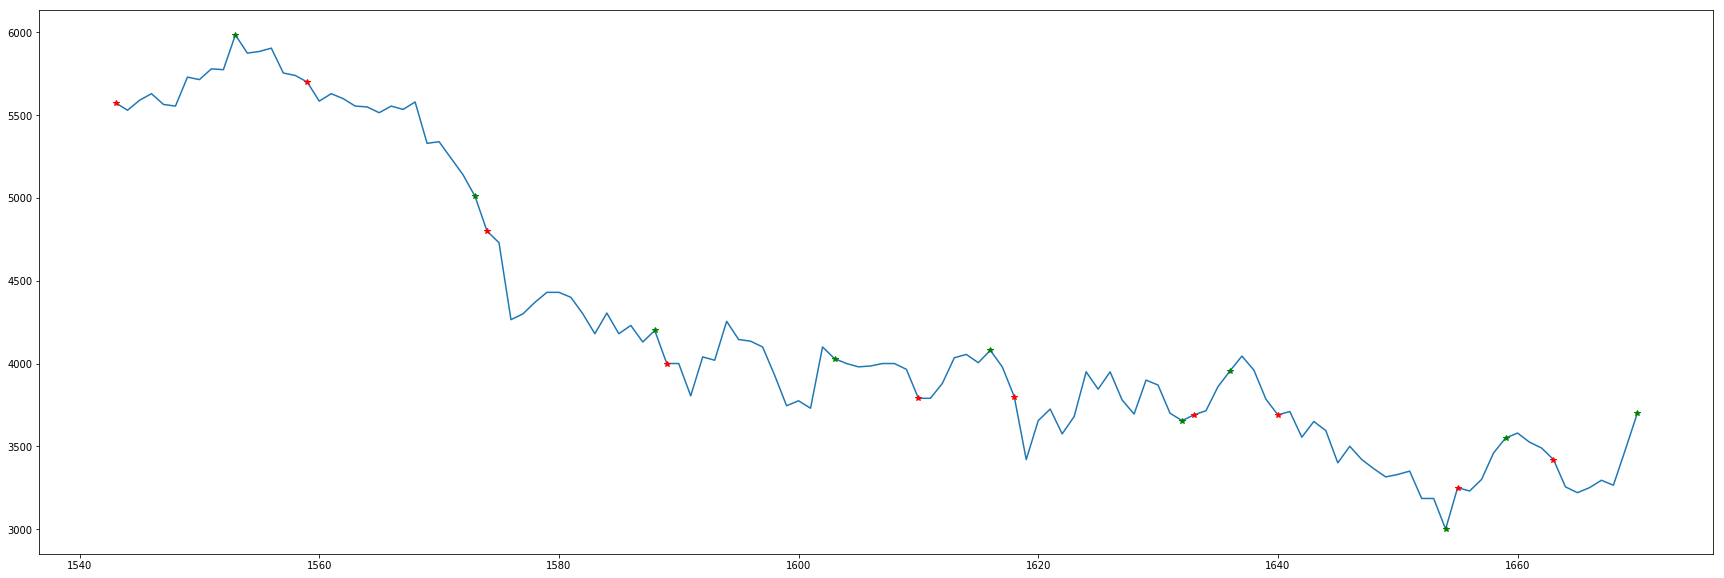

3443


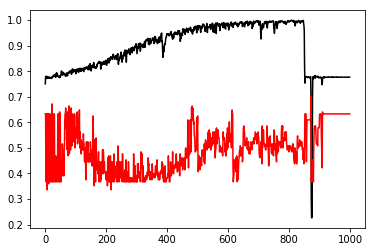

1536/1536 [==============================] - 0s 38us/step
train_score: [3.599288289745649, 0.7766927083333334]
128/128 [==============================] - 0s 37us/step
test_score: [5.918363094329834, 0.6328125]
----
18.27 29.17
----
32.21 41.3
----
26.92 41.08
----
52.97 42.53
----
36.88 58.64
----
20.16 28.25
----
9.7 17.59
profit: 52.5
---------------
[[277.0, 14, 'BUY'], [276.0, 28, 'SELL'], [267.5, 30, 'BUY'], [295.5, 36, 'SELL'], [252.0, 47, 'BUY'], [271.0, 52, 'SELL'], [278.0, 53, 'BUY'], [306.5, 64, 'SELL'], [307.0, 76, 'BUY'], [338.0, 90, 'SELL'], [317.0, 107, 'BUY'], [244.5, 121, 'SELL'], [238.5, 122, 'BUY'], [258.0, 125, 'SELL']]


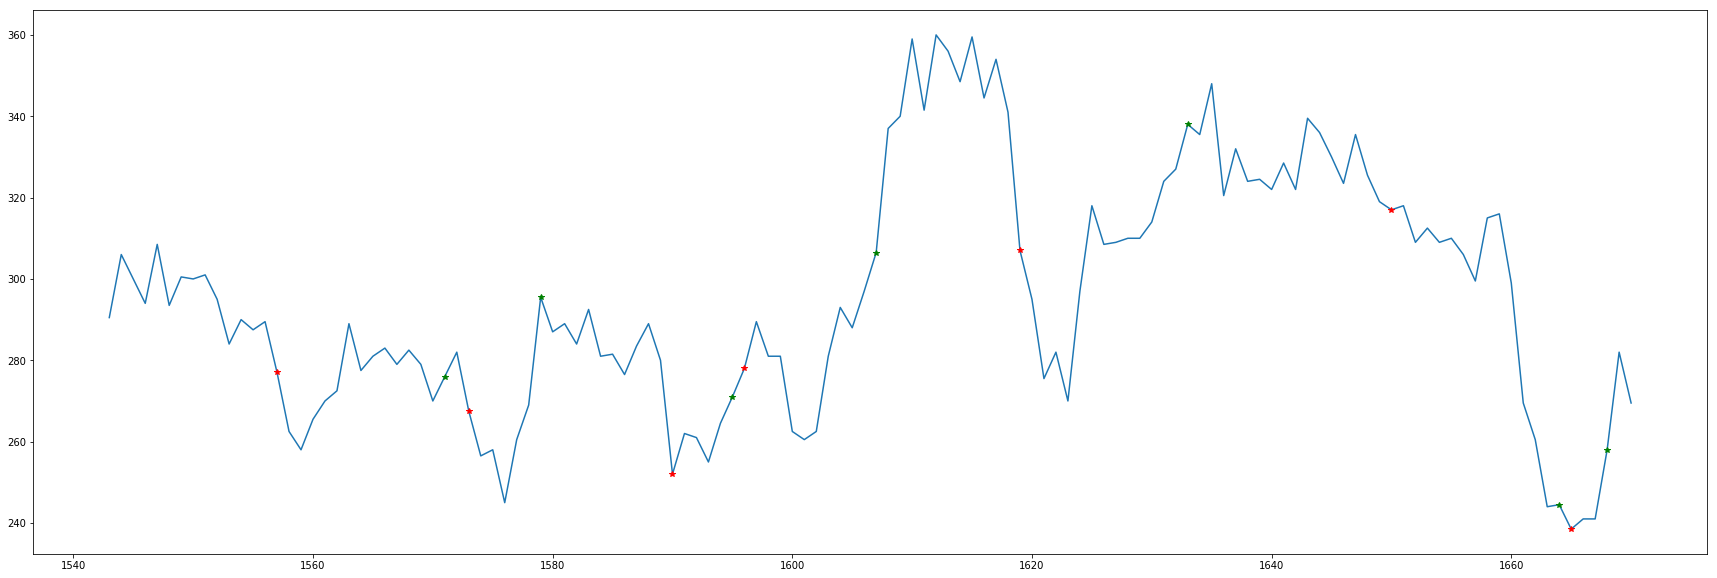

3665


KeyError: 'K'

In [41]:

for stock_num in stocks:
    print(stock_num)
    feature_list = ['Open', 'High', 'Low', 'Close','Vol','RSI6','SMA5','MA5']
    batch_size= 128
    LR= 0.005
    epoch= 1000
    input_size= 6
    time_steps= 6
    sd = 3
    input_size = len(feature_list)
    
    model =Sequential()
    model.add(LSTM(
                batch_input_shape=(batch_size,time_steps,input_size),
                output_dim=256,
                return_sequences=True,
                stateful=False,
            ))
    model.add(Dropout(0.6))
    model.add(LSTM(
            output_dim=128,
                return_sequences=False,
                stateful=False,
             ))
    model.add(Dropout(0.6))
    model.add(Dense(256))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Dropout(0.4))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Dense(2,activation='softmax'))
    adam = Adam(LR)
    #     model.summary()
    model.compile(optimizer=adam,
                      loss='categorical_crossentropy',metrics=['accuracy'])
    X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test,df=batch_data(stock_num,time_steps,-sd,batch_size,feature_list)
    train_history=model.fit(X_t_batch_train, Y_t_batch_train, epochs=epoch, batch_size=batch_size,verbose=0,validation_data=(X_t_batch_test,Y_t_batch_test),shuffle=True)
    plt.plot(train_history.history['acc'],color='black')
    plt.plot(train_history.history['val_acc'],color='red')
    plt.show()

    score = model.evaluate(X_t_batch_train,Y_t_batch_train, verbose=1,batch_size=128)
    print('train_score:', score)
    score = model.evaluate(X_t_batch_test,Y_t_batch_test, verbose=1,batch_size=128)
    print('test_score:', score)




    df1 = pd.read_csv('data/'+str(stock_num)+'.csv' , encoding='big5')
    df_val = df1[-batch_size:]
    predictions = Y_t_batch_test[:,1]
    holding = 0

    trade_record=[]
    profit=[]
    for i in range(len(predictions)):
        prediction = predictions[i]
        price = float(df_val.iloc[i]['Close'])
        K = float(df_val.iloc[i]['K'].replace('%',''))
        D = float(df_val.iloc[i]['D'].replace('%',''))
        RSI = float(df_val.iloc[i]['RSI 6'].replace('%',''))

        if holding == 0:
            if prediction ==1 or (K<30 and D<30) or (RSI < 40) :
                print('----')
                print(K,D)



                p_d = [price,i,'BUY']
                trade_record.append(p_d)
                holding=1
                continue
        if holding ==1:
            last_trade = trade_record[-1]
            if last_trade[2]=='BUY':
                buy_price=last_trade[0]
                buy_i = last_trade[1]
                if (price/buy_price-1)>0.07 or i-buy_i>=14 or ((RSI > 75) and (K>70 and D>70)) :
    #                 print((buy_i-i))eleven
                    p_d_s=[price,i,'SELL']
                    trade_record.append(p_d_s)
                    holding=0
                    profit.append(price-buy_price)
    p = sum(profit)
    print('profit:',p)
    print('---------------')
    print(trade_record)
    start = df_val['Close'].index[0]
    plt.figure(figsize = (30,10))
    plt.plot(df_val['Close'])
    for i in trade_record:
        x=i[1]+start 
        y = i[0]
        action = i[2]
        if action=='BUY':
            plt.plot(x,y,color='red',marker='*')
        else:
            plt.plot(x,y,color='green',marker='*')
    plt.show()


